FRAGE: 
Welche Änderungen erzeugen ein lineares Ausgangsverhalten und welche Änderungen führen zu starkem "Overfitting"?

ANTWORT: 

Um ein lineares Ausgangsverhalten zu erzeugen setzt man die Anzahl der versteckten Neuronen auf eins, weil ein einzelnes Neuron eine lineare Aktivierungsfunktion hat und daher eine lineare Ausgabe erzeugt. Zudem verwendet man eine niedrige Lernrate (beispielsweise 1e-5), weil eine niedrige Lernrate dem Modell ermöglicht sich langsam an die Daten anzupassen und eine lineare Ausgabe erzeugt.

Wenn man jedoch die Anzahl der versteckten Neuronen erhöht, dann steigt die Modellkomplexität und dies kann zu "Overfitting" führen.  Die Wahl ungünstiger Hyperparameter, wie einer zu hohen Lernrate kann ebenfalls zu "Overfitting" führen. Eine zu hohe Lernrate kann dazu führen, dass das Modell die Trainingsdaten zu schnell "überanpasst".

FRAGE: 
Welche Faktoren spielen bei der Trainingsdauer eine Rolle?

ANTWORT: 
1. Datenmenge: Die Größe des Trainingsdatensatztes kann die Trainingsdauer beeinflussen.
2. Modellarchitektur: Modelle mit vielen Schichten und Neuronen erfordern normalerweise mehr Rechenleistung und längere Trainingszeiten.
3. Rechenleistung: Die verfügbare Rechenleistung des verwendeten Computers oder der verwendeten Hardware kann die Trainingsdauer beeinflussen.
4. Optimierungsalgorithmus: Der gewählte Optimierungsalgorithmus und dessen Parameter können die Trainingsdauer beeinflussen.
5. Hyperparamter: Die Wahl der Hyperparameter wie zum Beispiel die Lernrate und Anzahl der Trainingsepochen kann die Trainingsdauer beeinflussen.
6. Vorverarbeitung der Daten: Die Vorverarbeitungsschritte, die auf die Daten angewendet werden, können die Trainingsdauer beeinflussen.

In [238]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time

# Daten laden:

values = np.loadtxt('winequality_white.csv', dtype=np.float32, delimiter=";",
skiprows=1)

t_u = values[:, 0:11].astype(np.float32)  # input
t_c = values[:, 11].astype(np.float32)  # output

t_u = torch.tensor(t_u).unsqueeze(1)
t_c = torch.tensor(t_c).unsqueeze(1)

In [239]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

# Normierung Spaltenweise durchführen:
t_un_train = torch.zeros_like(t_u_train)
t_un_val = torch.zeros_like(t_u_val)

for i in range(t_u_train.shape[2]):
    t_un_train[:,:,i] = 0.1 * t_u_train[:,:,i]
    t_un_val[:,:,i] = 0.1 * t_u_val[:,:,i]

In [240]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    
    start_time = time.time()  # Startzeitpunkt des Trainings

    train_losses = []  # Liste für Trainingsverluste
    val_losses = []  # Liste für Validierungsverluste

    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        train_losses.append(loss_train.item())  # Trainingsverlust speichern
        val_losses.append(loss_val.item())  # Validierungsverlust speichern

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
            
    end_time = time.time()  # Endzeitpunkt des Trainings
    duration = end_time - start_time  # Zeitdauer berechnen
    print(f"Dauer des Trainings: {duration:.2f} Sekunden")

    return train_losses, val_losses


In [241]:
# Modell definieren:

neuron_count = 500
output_size = 1
input_size = 11  

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(input_size, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, output_size))
]))

# Training durchführen:

optimizer = optim.SGD(seq_model.parameters(), lr=1e-5)

train_losses, val_losses = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer, 
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 41.3653, Validation loss 41.4669
Epoch 1000, Training loss 0.9662, Validation loss 0.9423
Epoch 2000, Training loss 0.9519, Validation loss 0.9278
Epoch 3000, Training loss 0.9392, Validation loss 0.9148
Epoch 4000, Training loss 0.9277, Validation loss 0.9032
Epoch 5000, Training loss 0.9174, Validation loss 0.8927
Dauer des Trainings: 287.17 Sekunden


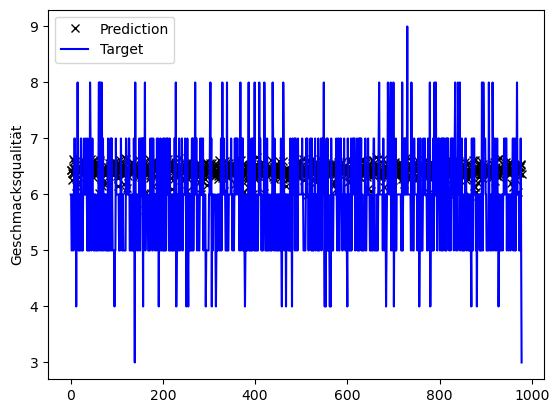

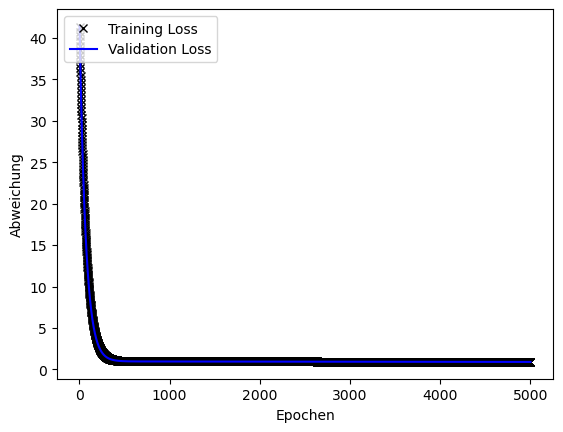

In [242]:
# Vorhersage plotten:
t_range = torch.arange(20., 90., step=5).unsqueeze(1)

results = seq_model(t_u_val)
fig = plt.figure(dpi=100)
plt.plot(results[:,0,0].detach().numpy(), 'kx', label="Prediction") 
plt.plot(t_c_val[:,0].detach().numpy(), 'b-', label="Target") 
plt.ylabel("Geschmacksqualität")
plt.legend(loc="upper left")
plt.show()

epochs = range(1, len(train_losses) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs, train_losses, 'kx', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.xlabel("Epochen")
plt.ylabel("Abweichung")
plt.legend(loc="upper left")
plt.show()
